# Tarea 2
### Ejercicio 3

## Jonathan Alexis Urrutia Anguiano 41401102-5

In [12]:
from pylab import *
%matplotlib inline

En este ejercicio se graficará la trayectoria que sigue una pelota al caer sobre un plano inclinado dadas las condiciones iniciales. Para resolver la ecuación diferencial se utilizará el método de Runge-Kutta de cuarto orden:

In [13]:
def rk4(ec,p_ini,x,args=0,h=0.01):
    if (x[1]-x[0]) <= 5.*h:
        h = (x[1]-x[0])/10
    tiempos = arange(x[0],x[1]+h,h)
    sol = zeros((len(tiempos),len(p_ini)))
    sol[0,:] = p_ini
    if args==0:
        for i in xrange(len(tiempos)-1):
            k1 = ec(sol[i,:],tiempos[i])
            k2 = ec(sol[i,:]+0.5*h*k1,tiempos[i]+0.5*h)
            k3 = ec(sol[i,:]+0.5*h*k2,tiempos[i]+0.5*h)
            k4 = ec(sol[i,:]+h*k3,tiempos[i]+h)
            sol[i+1,:]=sol[i,:]+(h/6.)*(k1+2*k2+2*k3+k4)
    else:
        for i in xrange(len(tiempos)-1):
            k1 = ec(sol[i,:],tiempos[i],args)
            k2 = ec(sol[i,:]+0.5*h*k1,tiempos[i]+0.5*h,args)
            k3 = ec(sol[i,:]+0.5*h*k2,tiempos[i]+0.5*h,args)
            k4 = ec(sol[i,:]+h*k3,tiempos[i]+h,args)
            sol[i+1,:]=sol[i,:]+(h/6.)*(k1+2*k2+2*k3+k4)
    return tiempos,sol

Sabemos que la ecuación de movimiento es la siguiente:
$$ m \ddot{\vec r} = -mg \hat{e_y} + fric(\dot{\vec{r}}),$$
donde $ fric(\dot{\vec{r}})$ es una función que depende únicamente de las velocidad. En este caso se asumirá que esta función es es una fuerza proporcional a la velocidad o bien, al cuadrado de la velocidad. Es decir:
$$ m \ddot{\vec r} = -mg \hat{e_y} + \gamma \dot{\vec{r}}   ---------- (1)\\
m \ddot{\vec r} = -mg \hat{e_y} + \gamma ||\dot{\vec{r}}|| \vec{\dot r}  --------- (2)
$$

Como queremos resolver un plano inclinado, se hará una rotación de $\theta$ para colocar al plano sobre el eje $x'$
$$
\left(\begin{array}{c}x'\\y' \end{array}\right) = \left(\begin{array}{c c}\cos\theta & -\sin\theta\\\sin\theta & \cos\theta \end{array}\right) \left(\begin{array}{c}x\\y \end{array}\right) 
$$

Haciendo los cambios de variable $u_1 = x',\, u_2 = \dot x', \, v_1 = y'\mbox{ y } v_2 = \dot y'$, el sistema de ecuaciones a resolver es el siguiente:

$$
\left(\begin{array}{c}\dot u_1 \\ \dot v_1 \\ \dot u_2\\ \dot v_2\end{array}\right) = \left(\begin{array}{c} u_2 \\ v_2 \\ \frac{1}{m} fric(u_1)\\-g +\frac{1}{m} fric(v_1)\end{array}\right)
$$

Con la transformación de coordenadas:
$$
\left(\begin{array}{c}x'\\y'\\\dot x'\\\dot y' \end{array}\right) = \left(\begin{array}{c c c c}\cos\theta & -\sin\theta & 0 & 0\\\sin\theta & \cos\theta & 0 &0 \\0&0& \cos\theta & -\sin\theta\\0&0&\sin\theta & \cos\theta \end{array}\right) \left(\begin{array}{c}x\\y\\\dot x \\ \dot y \end{array}\right) 
$$

In [14]:
def rotacion_sist(ang):
    ang = ang*pi/180.
    return array([cos(ang),-sin(ang),0,0]),array([sin(ang),cos(ang),0,0]),array([0,0,cos(ang),-sin(ang)]),array([0,0,sin(ang),cos(ang)])

Los modelos de fricción descritos en (1) y (2) y descompuestos en componentes son los siguientes:

In [15]:
def fric_v(v,gamma=0.1):
    f_x = gamma*v[0]
    f_y = gamma*v[1]
    return array([f_x,f_y]) 

def fric_v2(v,gamma=0.1):
    norm_v = sqrt(v[0]**2 + v[1]**2)
    f_x = gamma*norm_v*v[0]
    f_y = gamma*norm_v*v[1]
    return array([f_x,f_y]) 

La ecuación de movimiento a resolver(ya con la rotación) es:

In [49]:
 #Antes debe definirse el valor de la variable ang, de lo contratrio la función no podrá trabajar
def e_mov_r(r_v,t,fric=0, g=9.8,m=1):
    dx = r_v[2]
    dy = r_v[3]
    if fric == 0:
        dvx,dvy = 0,-g
    else:
        dvx = - fric([r_v[2],r_v[3]])[0]/m
        dvy = -g- fric([r_v[2],r_v[3]])[1]/m
    return dot(rotacion_sist(ang),array([dx,dy,dvx,dvy]))
    #return array([dx,dy,dvx,dvy])

El problema con esta función es que debe de declararse explícitamente la variable $ang$ que es el ángulo que tiene le plano inclinado.

Vamos a definir también la función de rebote, y la del plano que nos interesa:

In [50]:
def plano(x,angulo):
    return -tan(angulo*pi/180.)*x

In [51]:
def rebote(r_v_i,mi_dt,modelo_fric=0):
    dt_busqueda = mi_dt/2
    y_izq = r_v_i
    t,sol = rk4(e_mov_r,r_v_i,[0,dt_busqueda],modelo_fric)
    y_med = sol[-1,:]

    while abs(y_izq[1])>1e-5:
        if y_izq[1]*y_med[1]<0:
            reinicio = y_izq
        else:
            reinicio = y_med
        dt_busqueda = dt_busqueda/2
        t, sol = rk4(e_mov_r, reinicio,[0,dt_busqueda],modelo_fric)
        y_izq = reinicio
        y_med = sol[-1,:]
    y_izq = array([y_izq[0],y_izq[1],y_izq[2],-y_izq[3]])
    return y_izq

Además vamos a definir una función que haga todo el cálculo y que regrese los datos en los coordenadas originales:

In [52]:
def datos_graf(cond_ini, ang, modelo_fric=0,pts=100, dt=0.1):
    N = pts
    inicio = cond_ini
    trayectoria = zeros((N,len(inicio)))
    mi_dt = dt
    trayectoria[0,:] = array(inicio)
    for i in range(N-1):
        t,sol_dt = rk4(e_mov_r,trayectoria[i,:],[0,mi_dt], modelo_fric)
    
        if sol_dt[-1,:][1] < 0:
            y_izq = rebote(trayectoria[i,:],mi_dt)    
            trayectoria[i+1,:] = y_izq
        else:
            trayectoria[i+1,:] = sol_dt[-1,:]
    for i in range(N):
        trayectoria[i,:] = dot(rotacion_sist(-ang),trayectoria[i,:])
    return trayectoria

###  a) y b)
Veremos el caso para el plano con un ángulo de $0^{\circ}$, $15^{\circ}$, $30^{\circ}$ y $45^{\circ}$  , con vel. iniciales positivas y con los modelos de fricción distintos y considerando el caso ideal de no fricción.

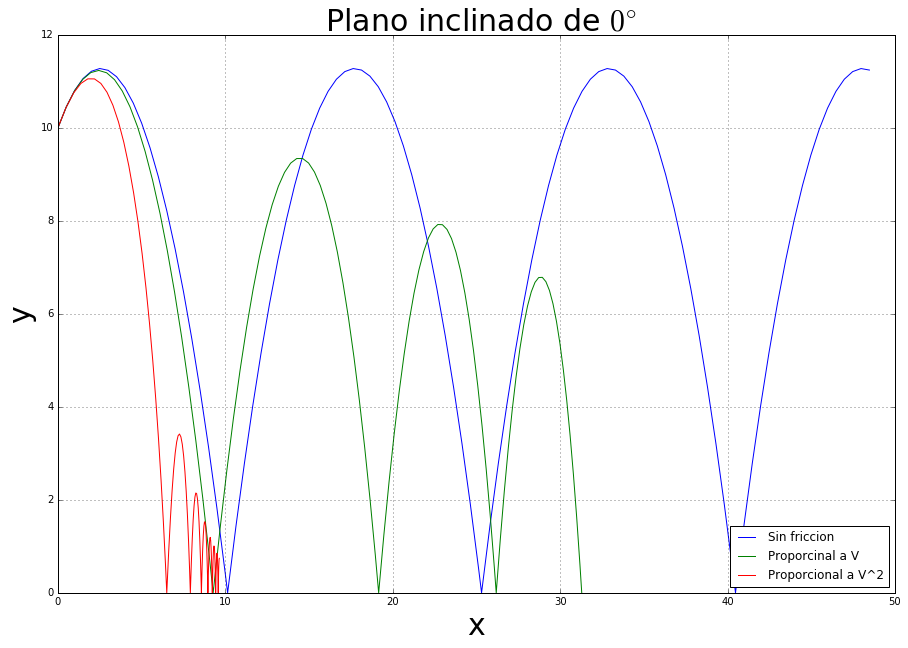

In [53]:
fig, ax = plt.subplots(figsize=(15, 10))
grid(True)
title(r' Plano inclinado de $0^{\circ}$',fontsize = 30),xlabel('x',fontsize=30),ylabel('y',fontsize = 30)

ang = 0
modelos = [0 , fric_v, fric_v2]
etiquetas = ['Sin friccion','Proporcinal a V','Proporcional a V^2']

for i in xrange(len(modelos)):
    trayectoria = datos_graf([0,10,5,5],ang,modelos[i],100)
    plot(trayectoria[:,0],trayectoria[:,1],'-', label = str(etiquetas[i]))
plot(trayectoria[:,0],plano(trayectoria[:,0],ang))
ax.legend(loc='lower right')
show()

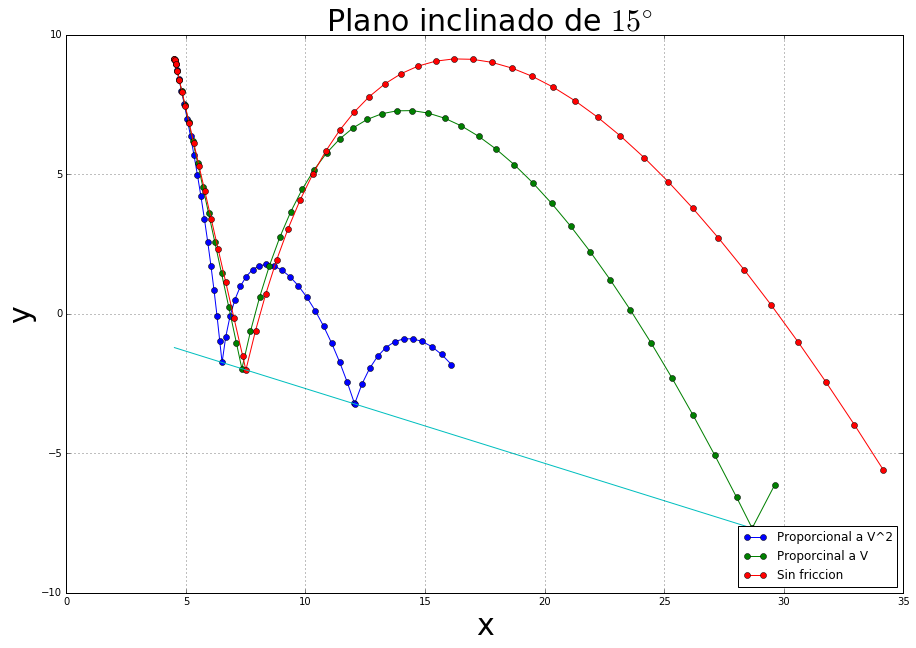

In [58]:
fig, ax = plt.subplots(figsize=(15, 10))
grid(True)
title(r' Plano inclinado de $15^{\circ}$',fontsize = 30),xlabel('x',fontsize=30),ylabel('y',fontsize = 30)

ang = 15.
modelos = [0 , fric_v, fric_v2]
etiquetas = ['Sin friccion','Proporcinal a V','Proporcional a V^2']

for i in xrange(len(modelos)):
    trayectoria = datos_graf([2,10,0,0],ang,modelos[2-i],50)
    plot(trayectoria[:,0],trayectoria[:,1],'o-',label = str(etiquetas[2-i]))
plot(trayectoria[:,0],plano(trayectoria[:,0],ang))
ax.legend(loc='lower right')
show()

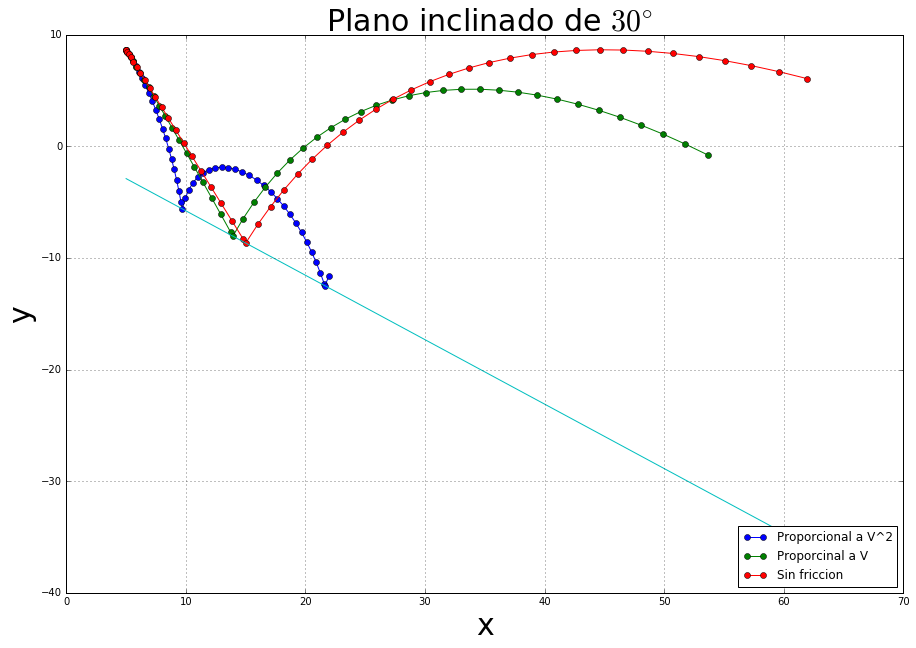

In [55]:
fig, ax = plt.subplots(figsize=(15, 10))
grid(True)
title(r' Plano inclinado de $30^{\circ}$',fontsize = 30),xlabel('x',fontsize=30),ylabel('y',fontsize = 30)

ang = 30.
modelos = [0 , fric_v, fric_v2]
etiquetas = ['Sin friccion','Proporcinal a V','Proporcional a V^2']

for i in xrange(len(modelos)):
    trayectoria = datos_graf([0,10,0,0],ang,modelos[2-i],50)
    plot(trayectoria[:,0],trayectoria[:,1],'o-',label = str(etiquetas[2-i]))
plot(trayectoria[:,0],plano(trayectoria[:,0],ang))
ax.legend(loc='lower right')
show()

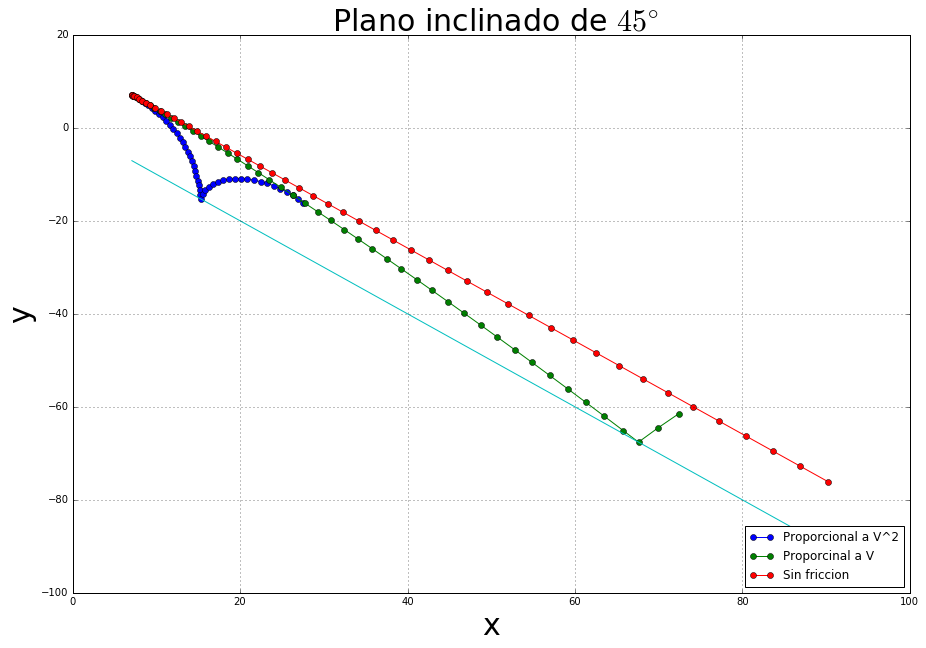

In [56]:
fig, ax = plt.subplots(figsize=(15, 10))
grid(True)
title(r' Plano inclinado de $45^{\circ}$',fontsize = 30),xlabel('x',fontsize=30),ylabel('y',fontsize = 30)

ang = 45.
modelos = [0 , fric_v, fric_v2]
etiquetas = ['Sin friccion','Proporcinal a V','Proporcional a V^2']

for i in xrange(len(modelos)):
    trayectoria = datos_graf([0,10,0,0],ang,modelos[2-i],50)
    plot(trayectoria[:,0],trayectoria[:,1],'o-',label = str(etiquetas[2-i]))
plot(trayectoria[:,0],plano(trayectoria[:,0],ang))
ax.legend(loc='lower right')
show()